In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Directory containing the data files
directory = "/home/sdruci/QIC/QIC/03_Assignement/data"

# Loop through files in the directory
for filename in os.listdir(directory):
    # Process files matching the expected naming pattern for different flags
    if filename.startswith('ALL') and filename.endswith('.dat'):
        # Extract the flag from the filename
        flag = filename.split('_')[-1].split('.')[0]  # e.g., 'O2'

        # Full path to the file
        path = os.path.join(directory, filename)

        # Read the file into a DataFrame
        df_all = pd.read_csv(path, sep=r'\s+', header=None, 
                             names=['Size', 'Explicit(i-j-k)', 'Column-major(i-k-j)', 'MATMUL'], skiprows=1)

        # Create individual DataFrames based on specific methods
        globals()[f"df_matmul_{flag}"] = df_all[['Size', 'MATMUL']].copy()
        globals()[f"df_row_col_{flag}"] = df_all[['Size', 'Explicit(i-j-k)']].copy()
        globals()[f"df_col_row_{flag}"] = df_all[['Size', 'Column-major(i-k-j)']].copy()

        # Display or further process each DataFrame
        print(f"Loaded all the DataFrames with the 3 methods for flag '{flag}'")


Loaded all the DataFrames with the 3 methods for flag 'O2'
Loaded all the DataFrames with the 3 methods for flag 'O1'
Loaded all the DataFrames with the 3 methods for flag 'O3'
Loaded all the DataFrames with the 3 methods for flag 'O1'


In [3]:
# loading the dataframes

matmul_O1 = df_matmul_O1['MATMUL']
matmul_O2 = df_matmul_O2['MATMUL']
matmul_O3 = df_matmul_O3['MATMUL']

row_col_O1 = df_row_col_O1['Explicit(i-j-k)']
row_col_O2 = df_row_col_O2['Explicit(i-j-k)']
row_col_O3 = df_row_col_O3['Explicit(i-j-k)']

col_row_O1 = df_col_row_O1['Column-major(i-k-j)']
col_row_O2 = df_col_row_O2['Column-major(i-k-j)']
col_row_O3 = df_col_row_O3['Column-major(i-k-j)']

size = df_all['Size']

In [4]:
# deducing the Nmin, Nmax and n_points parameters
N_min = df_all['Size'][0]
N_max = df_all['Size'][len(df_all['Size'])-1]
n_points = len(df_all['Size'])

print("N_min = ", N_min)
print("N_max = ", N_max)
print("N_points = ", n_points)

N_min =  100
N_max =  2500
N_points =  25


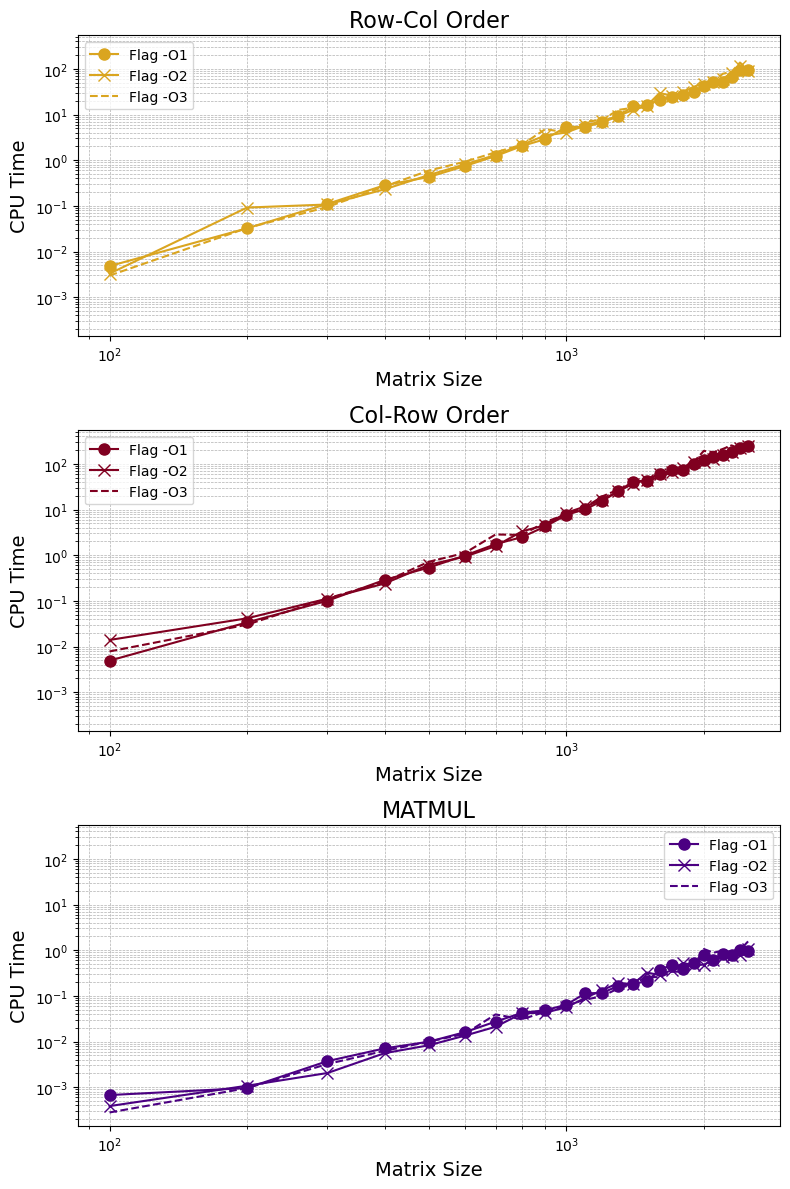

In [5]:
import matplotlib.pyplot as plt

# Set up the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False, sharey=True)  # 3 rows, 1 column

# Plot each method in a different subplot
# Row-Col order plot
axes[0].plot(size, row_col_O1, color='#DAA520', linestyle='-', marker='o', markersize=8, label='Flag -O1')
axes[0].plot(size, row_col_O2, color='#DAA520', linestyle='-', marker='x', markersize=8, label='Flag -O2')
axes[0].plot(size, row_col_O3, color='#DAA520', linestyle='--', markersize=8, label='Flag -O3')
axes[0].set_title("Row-Col Order", fontsize=16)
axes[0].legend()
axes[0].grid(True, which="both", linestyle='--', linewidth=0.5)

# Col-Row order plot
axes[1].plot(size, col_row_O1, color='#800020', linestyle='-', marker='o', markersize=8, label='Flag -O1')
axes[1].plot(size, col_row_O2, color='#800020', linestyle='-', marker='x', markersize=8, label='Flag -O2')
axes[1].plot(size, col_row_O3, color='#800020', linestyle='--', markersize=8, label='Flag -O3')
axes[1].set_title("Col-Row Order", fontsize=16)
axes[1].legend()
axes[1].grid(True, which="both", linestyle='--', linewidth=0.5)

# MATMUL plot
axes[2].plot(size, matmul_O1, color='#4B0082', linestyle='-', marker='o', markersize=8, label='Flag -O1')
axes[2].plot(size, matmul_O2, color='#4B0082', linestyle='-', marker='x', markersize=8, label='Flag -O2')
axes[2].plot(size, matmul_O3, color='#4B0082', linestyle='--', markersize=8, label='Flag -O3')
axes[2].set_title("MATMUL", fontsize=16)
axes[2].legend()
axes[2].grid(True, which="both", linestyle='--', linewidth=0.5)

# Set log-log scale for all subplots and label axes
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel("CPU Time", fontsize=14)

# Set x-label for the entire figure
axes[0].set_xlabel("Matrix Size", fontsize=14)
axes[1].set_xlabel("Matrix Size", fontsize=14)
axes[2].set_xlabel("Matrix Size", fontsize=14)

plt.tight_layout()
plt.show()


Fit parameters for Row-Col:
  Amplitude (A): 0.000 ± 0.000
  Exponent (r): 3.489 ± 0.250
  Chi-squared: 13.030
Fit parameters for Col-Row:
  Amplitude (A): 0.000 ± 0.000
  Exponent (r): 3.361 ± 0.074
  Chi-squared: 10.324
Fit parameters for MATMUL:
  Amplitude (A): 0.000 ± 0.000
  Exponent (r): 2.629 ± 0.134
  Chi-squared: 0.125


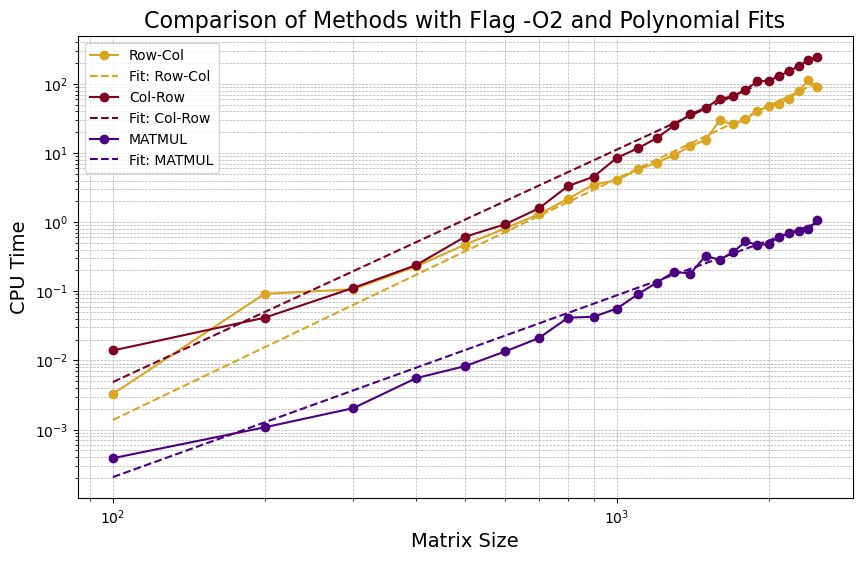

In [6]:
# Define the polynomial function
def poly(x, ampl, r):
    return ampl * (x ** r)

def poly_exponent(x, r):
    return (x ** r)

# Store the results for each fit in a dictionary
exponent_results = {}   # It will contain all the information about the fits

# Fit the data for each method
def fit_and_evaluate(x, y, label, color):
    # Perform the curve fitting
    popt, pcov = curve_fit(poly, x, y, p0=[70, 3])  # Initial guess for amplitude and exponent
    ampl, r = popt  # Unpack the optimal parameters
    fit_y = poly(x, *popt)  # Calculate fitted values

    # Calculate chi-squared statistic
    residuals = y - fit_y
    chi_squared = np.sum((residuals**2) / fit_y)
    
    # Calculate the errors on the parameters
    error = np.sqrt(np.diag(pcov))

    # Print results
    print(f"Fit parameters for {label}:")
    print(f"  Amplitude (A): {ampl:.3f} ± {error[0]:.3f}")
    print(f"  Exponent (r): {r:.3f} ± {error[1]:.3f}")
    print(f"  Chi-squared: {chi_squared:.3f}")

    exponent_results[label] = {
        "r": r, "r_err": error[1],
        "color": color
    }

    return fit_y

# Set up the plot
plt.figure(figsize=(10, 6))

# Fit and plot for Row-Col Order
fitted_row_col_O2 = fit_and_evaluate(size, row_col_O2, "Row-Col", '#DAA520')
plt.plot(size, row_col_O2, color='#DAA520', linestyle='-', marker='o', markersize=6, label='Row-Col')
plt.plot(size, fitted_row_col_O2, color='#DAA520', linestyle='--', label='Fit: Row-Col')

# Fit and plot for Col-Row Order
fitted_col_row_O2 = fit_and_evaluate(size, col_row_O2, "Col-Row", '#800020')
plt.plot(size, col_row_O2, color='#800020', linestyle='-', marker='o', markersize=6, label='Col-Row')
plt.plot(size, fitted_col_row_O2, color='#800020', linestyle='--', label='Fit: Col-Row')

# Fit and plot for MATMUL
fitted_matmul_O2 = fit_and_evaluate(size, matmul_O2, "MATMUL", '#4B0082')
plt.plot(size, matmul_O2, color='#4B0082', linestyle='-', marker='o', markersize=6, label='MATMUL')
plt.plot(size, fitted_matmul_O2, color='#4B0082', linestyle='--', label='Fit: MATMUL')

# Set log-log scale
plt.xscale('log')
plt.yscale('log')

# Axis labels with larger font size
plt.xlabel("Matrix Size", fontsize=14)
plt.ylabel("CPU Time", fontsize=14)

# Title and legend
plt.title("Comparison of Methods with Flag -O2 and Polynomial Fits", fontsize=16)
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.show()


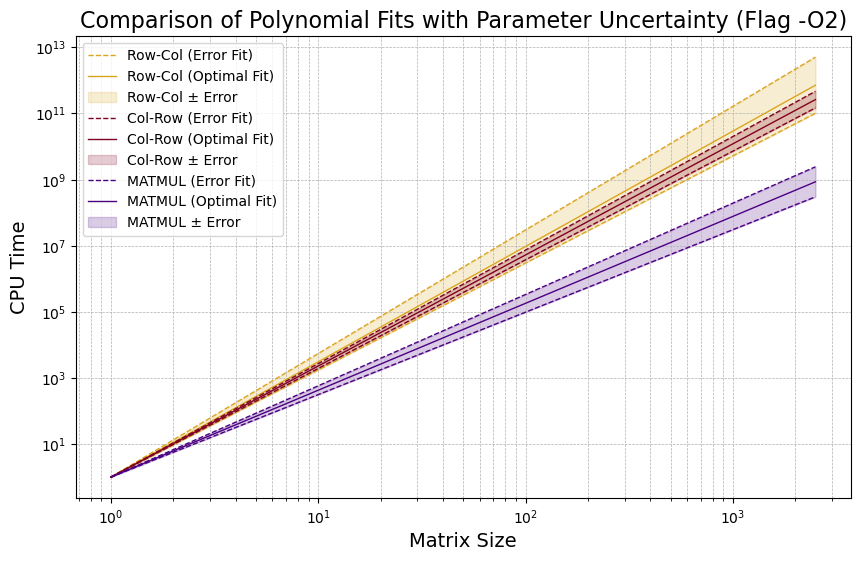

In [7]:
# Plot the fitted polynomials and shaded error regions
plt.figure(figsize=(10, 6))


label, params = next(iter(exponent_results.items()))

x_axis = np.arange(1,df_all['Size'][len(df_all['Size'])-1])  # example np.arange(0,2500)

for label, params in exponent_results.items():
    # Define the two polynomial lines with ± errors
    r, r_err = params["r"], params["r_err"]
    color = params["color"]
    # Generate fitted values for upper and lower bounds

    fit_y_upper = poly_exponent(x_axis, r + r_err)
    fit_y_lower = poly_exponent(x_axis, r - r_err)
    fit_y_optimal = poly_exponent(x_axis, r)
    # Plot the optimal polynomial fit
    plt.plot(x_axis, fit_y_lower, color=color, linestyle='--', linewidth = 1, label=f'{label} (Error Fit)')
    plt.plot(x_axis, fit_y_upper, color=color, linestyle='--', linewidth = 1)
    plt.plot(x_axis, fit_y_optimal, color=color, linestyle='-', linewidth = 1, label=f'{label} (Optimal Fit)')
    # Fill the area between the upper and lower bounds
    plt.fill_between(x_axis, fit_y_lower, fit_y_upper, color=color, alpha=0.2, label=f'{label} ± Error')

plt.xscale('log')
plt.yscale('log')

# Axis labels with larger font size
plt.xlabel("Matrix Size", fontsize=14)
plt.ylabel("CPU Time", fontsize=14)

# Title and legend
plt.title("Comparison of Polynomial Fits with Parameter Uncertainty (Flag -O2)", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.show()